# 데이터 불러오기

In [1]:
# 경고(warning) 비표시
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from itertools import product
from pulp import LpVariable, lpSum, value
from ortoolpy import model_min, addvars, addvals

# 데이터 불러오기
df_tc = pd.read_csv('trans_cost.csv', index_col="공장") #W-F 이동 시 발생하는 운송비용 -> 앞으로 이것을 최소화
df_demand = pd.read_csv('demand.csv') #공장(F)의 최소한의 필요 수요량
df_supply = pd.read_csv('supply.csv') #창고(W)의 최대 공급 가능량

display(df_tc, df_demand, df_supply)

,F1,F2,F3,F4
공장,,,,
W1,10,10,11,27
W2,18,21,12,14
W3,15,12,14,12


,F1,F2,F3,F4
0,28,29,31,25


,W1,W2,W3
0,35,41,42


In [3]:
#초기 설정
np.random.seed(1)
nw = len(df_tc.index) # W 창고 개수 :3
nf = len(df_tc.columns)# F 공장 개수 :4
pr = list(product(range(nw), range(nf))) # product 함수는 W(0~2)와 F (0~3)넘버를 중복없이 짝지어줌

print(pr)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)]


In [5]:
#수리 모델 작성
m1 = model_min() #목적 함수. 현재 초기화됨. -> 목적은 최소화! (이후 제약조건을 추가)
v1 = {(i, j) : LpVariable('v%d_%d'%(i, j), lowBound=0) for i, j in pr}

print(m1)
print(v1)

NoName:
MINIMIZE
None
VARIABLES

{(0, 0): v0_0, (0, 1): v0_1, (0, 2): v0_2, (0, 3): v0_3, (1, 0): v1_0, (1, 1): v1_1, (1, 2): v1_2, (1, 3): v1_3, (2, 0): v2_0, (2, 1): v2_1, (2, 2): v2_2, (2, 3): v2_3}


In [12]:
#목적함수 (m1)에 제약조건 추가

m1 += lpSum(df_tc.iloc[i][j] * v1[i,j] for i, j in pr) #목적함수 계산: 아깐 None이었는데 값이 추가되었다.

## 창고(W) - 창고별 총 공급량 <= 창고가 공급할 수 있는 최대량
for i in range(nw):# 4개
    m1 += lpSum(v1[i, j] for j in range(nf)) <= df_supply.iloc[0][i]

## 공장(F) - 공장별 총 수요량 >= 공장에서 필요로 하는 최소수요
for j in range(nf):
    m1 += lpSum(v1[i, j] for i in range(nw)) >= df_demand.iloc[0][j]
    
m1.solve() #최적해 구하기
    

1

In [13]:
# 결과
print(m1)

NoName:
MINIMIZE
10*v0_0 + 10*v0_1 + 11*v0_2 + 27*v0_3 + 18*v1_0 + 21*v1_1 + 12*v1_2 + 14*v1_3 + 15*v2_0 + 12*v2_1 + 14*v2_2 + 12*v2_3 + 0
SUBJECT TO
_C1: v0_0 + v0_1 + v0_2 + v0_3 <= 35

_C2: v1_0 + v1_1 + v1_2 + v1_3 <= 41

_C3: v2_0 + v2_1 + v2_2 + v2_3 <= 42

_C4: v0_0 + v1_0 + v2_0 >= 28

_C5: v0_1 + v1_1 + v2_1 >= 29

_C6: v0_2 + v1_2 + v2_2 >= 31

_C7: v0_3 + v1_3 + v2_3 >= 25

VARIABLES
v0_0 Continuous
v0_1 Continuous
v0_2 Continuous
v0_3 Continuous
v1_0 Continuous
v1_1 Continuous
v1_2 Continuous
v1_3 Continuous
v2_0 Continuous
v2_1 Continuous
v2_2 Continuous
v2_3 Continuous



In [14]:
# 최적해, 최적값 계산 #
df_tr_sol = df_tc.copy()
total_cost = 0

for k,x in v1.items():
    i,j = k[0],k[1]
    df_tr_sol.iloc[i][j] = value(x) #구해진 최적해 (v1)
    total_cost += df_tc.iloc[i][j]*value(x) #최적화 이후 총 비용값 (이는 원래비용 * 최적해(v1) = 최적값)
display(df_tr_sol) #최적해
print("총 운송 비용(최적값):", total_cost) #총 운송비용 (최적값)

,F1,F2,F3,F4
공장,,,,
W1,28,7,0,0
W2,0,0,31,5
W3,0,22,0,20


총 운송 비용(최적값): 1296.0


# 앞서 구한 최적 운송 경로를 네트워크 시각화

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

#데이터 불러오기
df_tr = df_tr_sol.copy() #가중치이자 최적해(v1)
df_pos = pd.read_csv('trans_route_pos.csv') #좌표

display(df_tr, df_pos)

,F1,F2,F3,F4
공장,,,,
W1,28,7,0,0
W2,0,0,31,5
W3,0,22,0,20


,W1,W2,W3,F1,F2,F3,F4
0,0,0,0,4.0,4.0,4.0,4.0
1,1,2,3,0.5,1.5,2.5,3.5


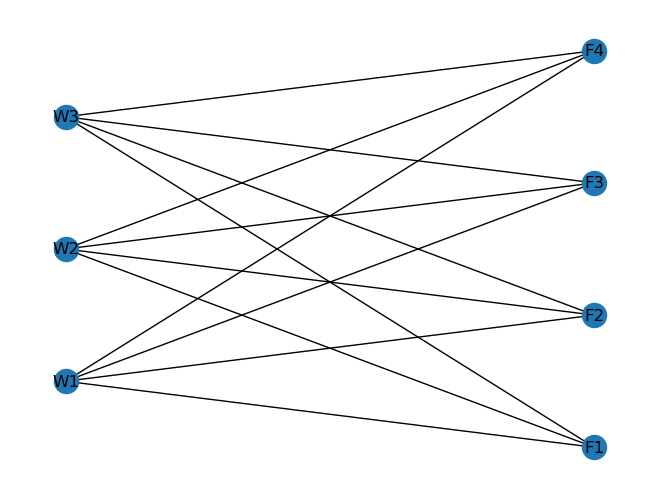

In [16]:
#가중치 반영 전
# 객체
G = nx.Graph()

#노드 설정(W 3개, F 4개)
for i in range(len(df_pos.columns)):
    G.add_node(df_pos.columns[i])
    
#엣지 설정
for i in range(0,3):
    for j in range(3, len(df_pos.columns)):
        G.add_edge(df_pos.columns[i], df_pos.columns[j])
#좌표 설정
pos = {}
for i in range(len(df_pos.columns)):
    node = df_pos.columns[i]
    pos[node] = (df_pos[node][0],df_pos[node][1])
#그리기
nx.draw(G, pos, with_labels=True)
plt.show()

In [17]:
#가중치 추가
sy = []
size = 0.1 #가중치 값이 너무 커서 줄임(그대로 쓰면 엣지가 굵다)
for i in range(len(df_tr.index)):
    for j in range(len(df_tr.columns)):
        sy.append(df_tr.iloc[i,j]*size)
sy

[2.8000000000000003,
 0.7000000000000001,
 0.0,
 0.0,
 0.0,
 0.0,
 3.1,
 0.5,
 0.0,
 2.2,
 0.0,
 2.0]

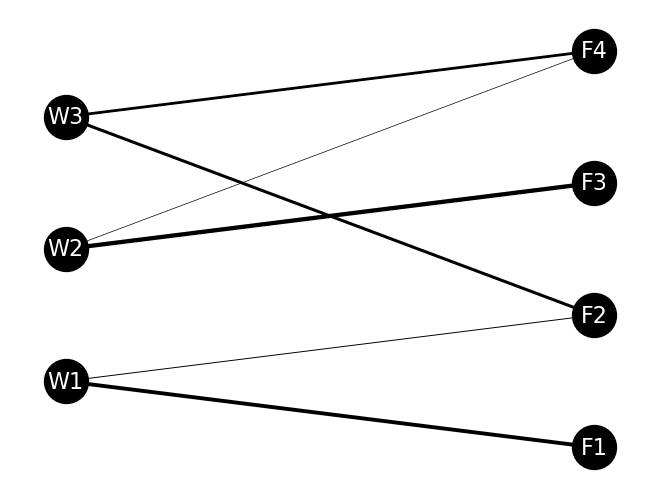

In [18]:
#그래프 다시 그리기
nx.draw(G, pos, with_labels=True, font_size = 16, node_size = 1000, node_color = 'k', font_color='w', width = sy) #width에 가중치 리스트 설정
plt.show()

# 제약 조건 만족?

In [19]:
#필요한 데이터
import pandas as pd
import numpy as np

df_demand = pd.read_csv('demand.csv')
df_supply = pd.read_csv('supply.csv')

display(df_demand, df_supply)

,F1,F2,F3,F4
0,28,29,31,25


,W1,W2,W3
0,35,41,42


In [20]:
# 제약조건 함수화 -> 앞서 만든 if문에서 수요(or 공급)을 만족하면 1, 아니면 0을 출력하도록 하는 flag를 만든다
#먼저 0으로 초기화시키고, 만족하는 경우엔 1을 넣어주기

# 공장(F)의 수요
def c_demand(df_tr, df_demand):
    
    #초기화
    flag = np.zeros(len(df_demand.columns))
    
    #계산
    for i in range(len(df_demand.columns)):
        temp_sum = sum(df_tr[df_demand.columns[i]])
        if temp_sum >= df_demand.iloc[0][i]:
            flag[i] = 1
            
    return flag
#창고(W)의 공급
def c_supply(df_tr, df_supply):
    
    #초기화
    flag = np.zeros(len(df_supply.columns))
    
    #계산
    for i in range(len(df_supply.columns)):
        temp_sum = sum(df_tr.loc[df_supply.columns[i]])
        if temp_sum <= df_supply.iloc[0][i]:
            flag[i] = 1
    return flag



In [23]:
import pandas as pd

df_m = pd.read_csv('product_plan_material.csv', index_col="제품")
print(df_material)
df_p = pd.read_csv('product_plan_profit.csv', index_col="제품")
print(df_profit)
df_s = pd.read_csv('product_plan_stock.csv', index_col="항목")
print(df_stock)
df_plan = pd.read_csv('product_plan.csv', index_col="제품")
print(df_plan)

display(df_m, df_p, df_s, df_plan)

     원료1  원료2  원료3
제품                
제품1    1    4    3
제품2    2    4    1
      이익
제품      
제품1  5.0
제품2  4.0
    원료1  원료2  원료3
항목               
재고   40   80   50
      생산량
제품       
제품1    16
제품2     0


,원료1,원료2,원료3
제품,,,
제품1,1,4,3
제품2,2,4,1


,이익
제품,
제품1,5.0
제품2,4.0


,원료1,원료2,원료3
항목,,,
재고,40,80,50


,생산량
제품,
제품1,16
제품2,0


# 목적함수 만들기

In [25]:
def product_plan(df_profit, df_plan):
    profit = 0
    for i in range(len(df_profit.index)):
        profit += df_profit.iloc[i][0] * df_plan.iloc[i][0] # 이익 * 생산량
    return profit
print('총이익: ', product_plan(df_p, df_plan))

총이익:  80.0


# 생산 최적화 문제 풀기

In [26]:
import pandas as pd
from pulp import LpVariable, lpSum, value
from ortoolpy import model_max, addvars, addvals

m2 = model_max() #목적함수 - 이익 최대화가 목적
v2 = {(i) : LpVariable('v%d'%(i), lowBound=0) for i in range(len(df_p))}
print(v2)

{0: v0, 1: v1}


In [27]:
#이제 2에 제약조건 하나씩 추가

# 각 제품별 이익*생산량
m2 += lpSum(df_p.iloc[i] * v2[i] for i in range(len(df_p)))

#제약조건
for j in range(len(df_m.columns)): #j: 원료 0,1,2 / i:제품 0,1
    m2 += lpSum(df_m.iloc[i,j] * v2[i] for i in range(len(df_p))) <= df_s.iloc[:, j]#제약조건 : 각 제품에 필요한 생산량*원료합 <= 최대 원료 재고량

m2.solve() #최적해 구해줘

1

In [29]:
df_plan_sol = df_plan.copy()
display(df_plan_sol) #원래 생산계획

for k, x in v2.items():
    df_plan_sol.iloc[k] = value(x) #v2 최적해
    
display(df_plan_sol) # 최적으로 찾아낸 생산계획 (생산량)

,생산량
제품,
제품1,16
제품2,0


,생산량
제품,
제품1,15
제품2,5


In [30]:
print(value(m2.objective))

95.0


# 최적 생산계획이 제약조건 만족?

In [31]:
display(df_m, df_s, df_plan)
# df_m은 제품에 사용되는 원료비율, df_s는 원료 재고량, df_plan은 현재 제품 생산량(최적해 아님)

,원료1,원료2,원료3
제품,,,
제품1,1,4,3
제품2,2,4,1


,원료1,원료2,원료3
항목,,,
재고,40,80,50


,생산량
제품,
제품1,16
제품2,0


In [32]:
# 제약조건으로 규정한 '각 원료의 사용량'이 재고를 효율적으로 이용하고 있는가

def cond_stock(df_plan, df_material, df_stock):
    flag = np.zeros(len(df_material.columns)) #초기값
    
    for i in range(len(df_material.columns)): #i : 원료(0,1,2)
        temp_sum = 0
        
        for j in range(len(df_material.index)): #j:제품(0,1)
            #각 원료 대해 제품의 생산량*사용량 => temp_sum: 각 원료 총사용ㄹ야
            temp_sum = temp_sum + df_material.iloc[j][i] * float(df_plan.iloc[j])
        if (temp_sum <= float(df_stock.iloc[0][i])):
            flag[i] = 1
        print(df_material.columns[i] + '사용량: ' + str(temp_sum) + ', 재고:' + str(float(df_stock.iloc[0][i])))
    return flag


In [33]:
#출력: 원래의 df_plan 생산계획 하에서는
cond_stock(df_plan, df_m, df_s)

원료1사용량: 16.0, 재고:40.0
원료2사용량: 64.0, 재고:80.0
원료3사용량: 48.0, 재고:50.0


array([1., 1., 1.])